# 環境初始化

In [1]:
import os
os.chdir("work")

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import matplotlib.pyplot as plt
import json
import random
import time
import pandas as pd
%matplotlib inline

# 資料集格式範例

```json
# 檔案標頭
{
    "file": "1-FemaleNoGlasses-Normal",
    "size": 419,
    "fps": 30,
    "marker_path": "dataset/markers/1-FemaleNoGlasses-Normal.csv",
  "video_path": "dataset/YawDD/train/1-FemaleNoGlasses-Normal.avi"
}

# 標記內容
{
    "index": 1,
    "mode": "Normal",
    "level": "0",
    "mar": 0.025642701314247437,
    "ear_l": 0.2986032435056242,
    "ear_r": 0.3937485488274893,
    "entropy": -16089.327941184894,
    "roll": -2,
    "yaw": 37,
    "pitch": -12
}
```

# 功能函式

In [3]:
def norm_max_min(var, in_min, in_max, out_min=0, out_max=1):
    var = float(var)
    if var >= in_max:
        return out_max
    if var <= in_min:
        return out_min
    return (var - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

In [12]:
def readDataList(file):
    data_list = []
    with open(file, 'r', encoding='utf-8') as f:
        while True:
            line = f.readline()
            if len(line) == 0: break
            file_json = json.loads(line)
            mlist = []
            for _ in range(file_json['size']):
                mjson = json.loads(f.readline())
                mode = (mjson['mode'] == 'Yawning')
                mar = norm_max_min(mjson['mar'], 0, 1)
                ear_l = norm_max_min(mjson['ear_l'], 0, 1)
                ear_r = norm_max_min(mjson['ear_r'], 0, 1)
                entropy = norm_max_min(mjson['entropy'], 0, 30)
                # roll = norm_max_min(mjson['roll'], -50, 50)
                yaw = norm_max_min(mjson['yaw'], -50, 50)
                # pitch = norm_max_min(mjson['pitch'], -50, 50)
                mlist.append(np.array([
                    mode,
                    mar,
                    ear_l,
                    ear_r,
                    yaw,
                    entropy
                ]))
            data_list.append(np.array(mlist))
    return np.array(data_list)

In [5]:
def buildTrain(data_list, long=300):
  x_data, y_data = [], []
  for t in data_list:
    train = np.array(t)
    for i in range(train.shape[0]-long):
      x_data.append(train[i:i+long,1:])
      y_data.append(train[i+long-1][0])
  return np.array(x_data), np.array(y_data)

In [6]:
random_seed = 0
def shuffle(x_data, y_data):
    np.random.seed(random_seed)
    randomList = np.arange(x_data.shape[0])
    np.random.shuffle(randomList)
    return x_data[randomList], y_data[randomList]

In [7]:
def splitData(data_0, data_1, test_rate):
    data_0_train = data_0[int(data_0.shape[0] * test_rate):]
    data_0_test = data_0[:int(data_0.shape[0] * test_rate)]
    data_1_train = data_1[int(data_1.shape[0] * test_rate):]
    data_1_test = data_1[:int(data_1.shape[0] * test_rate)]
    return data_0_train, data_1_train, data_0_test, data_1_test

# 主程式

##### 建立訓練資料

In [106]:
train_list = readDataList('train_data.txt')
X_trains, Y_train = buildTrain(train_list, 300)
print(X_trains.shape, Y_train.shape)
X_trains, Y_train = shuffle(X_trains, Y_train)
X_trains, Y_train, X_tests, Y_test = splitData(X_trains, Y_train, 0.2)
X_tests, Y_test, X_vals, Y_val = splitData(X_tests, Y_test, 0.5)

<ipython-input-12-1c48fe578252>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data_list)


(127739, 300, 5) (127739,)


In [27]:
len(np.average(X_trains[:, :, 4], 0))

300

In [54]:
def seg_data(data):
    seg = [None] * 3
    seg[0] = data[:, :, 0:1] # mar list
    seg[1] = data[:, :, 1:4] # ear+yaw list
    seg[2] = np.average(data[:, :, 4], 1) # entropy
    print(f'{data.shape} -> {seg[0].shape} + {seg[1].shape} + {seg[2].shape}')
    return seg

X_train = seg_data(X_trains)
X_val = seg_data(X_vals)
X_test = seg_data(X_tests)

(102192, 300, 5) -> (102192, 300, 1) + (102192, 300, 3) + (102192,)
(12773, 300, 5) -> (12773, 300, 1) + (12773, 300, 3) + (12773,)
(12774, 300, 5) -> (12774, 300, 1) + (12774, 300, 3) + (12774,)


**訓練資料圖形化**

X_data = [47245,:,:], Y_data = 1.0


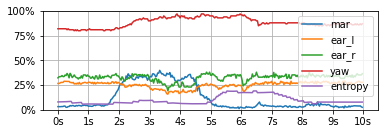

X_data = [36894,:,:], Y_data = 0.0


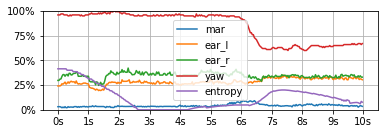

In [99]:
def drawTrain(sub, num):
    plt.subplot(210 + sub)
    plt.plot(X_trains[num,:,0], label='mar')
    plt.plot(X_trains[num,:,1], label='ear_l')
    plt.plot(X_trains[num,:,2], label='ear_r')
    plt.plot(X_trains[num,:,3], label='yaw')
    plt.plot(X_trains[num,:,4], label='entropy')
    print(f'X_data = [{num},:,:], Y_data = {Y_train[num]}')
    plt.ylim(0, 1)
    plt.legend()
    plt.xticks(np.linspace(0, 300, 11), [f'{int(x)}s' for x in (np.linspace(0,300,11) / 30)])
    plt.yticks(np.linspace(0, 1, 5), [f'{int(x * 100)}%' for x in (np.linspace(0, 1, 5))])
    plt.grid(True)
    plt.show()

def getRnd():
    return random.randint(0, X_trains.shape[0] - 1)

def draw():
    while True:
        rnd = getRnd()
        if Y_train[rnd] > 0.5:
            drawTrain(1, rnd)
            break
    while True:
        rnd = getRnd()
        if Y_train[rnd] <= 0.5:
            drawTrain(2, rnd)
            break
draw()

##### 建立訓練模型

params_num = 121249
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mar (InputLayer)          [(None, 300, 1)]     0                                            
__________________________________________________________________________________________________
input_ear (InputLayer)          [(None, 300, 3)]     0                                            
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 150, 32)      128         input_mar[0][0]                  
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 150, 32)      320         input_ear[0][0]                  
________________________________________________________________________

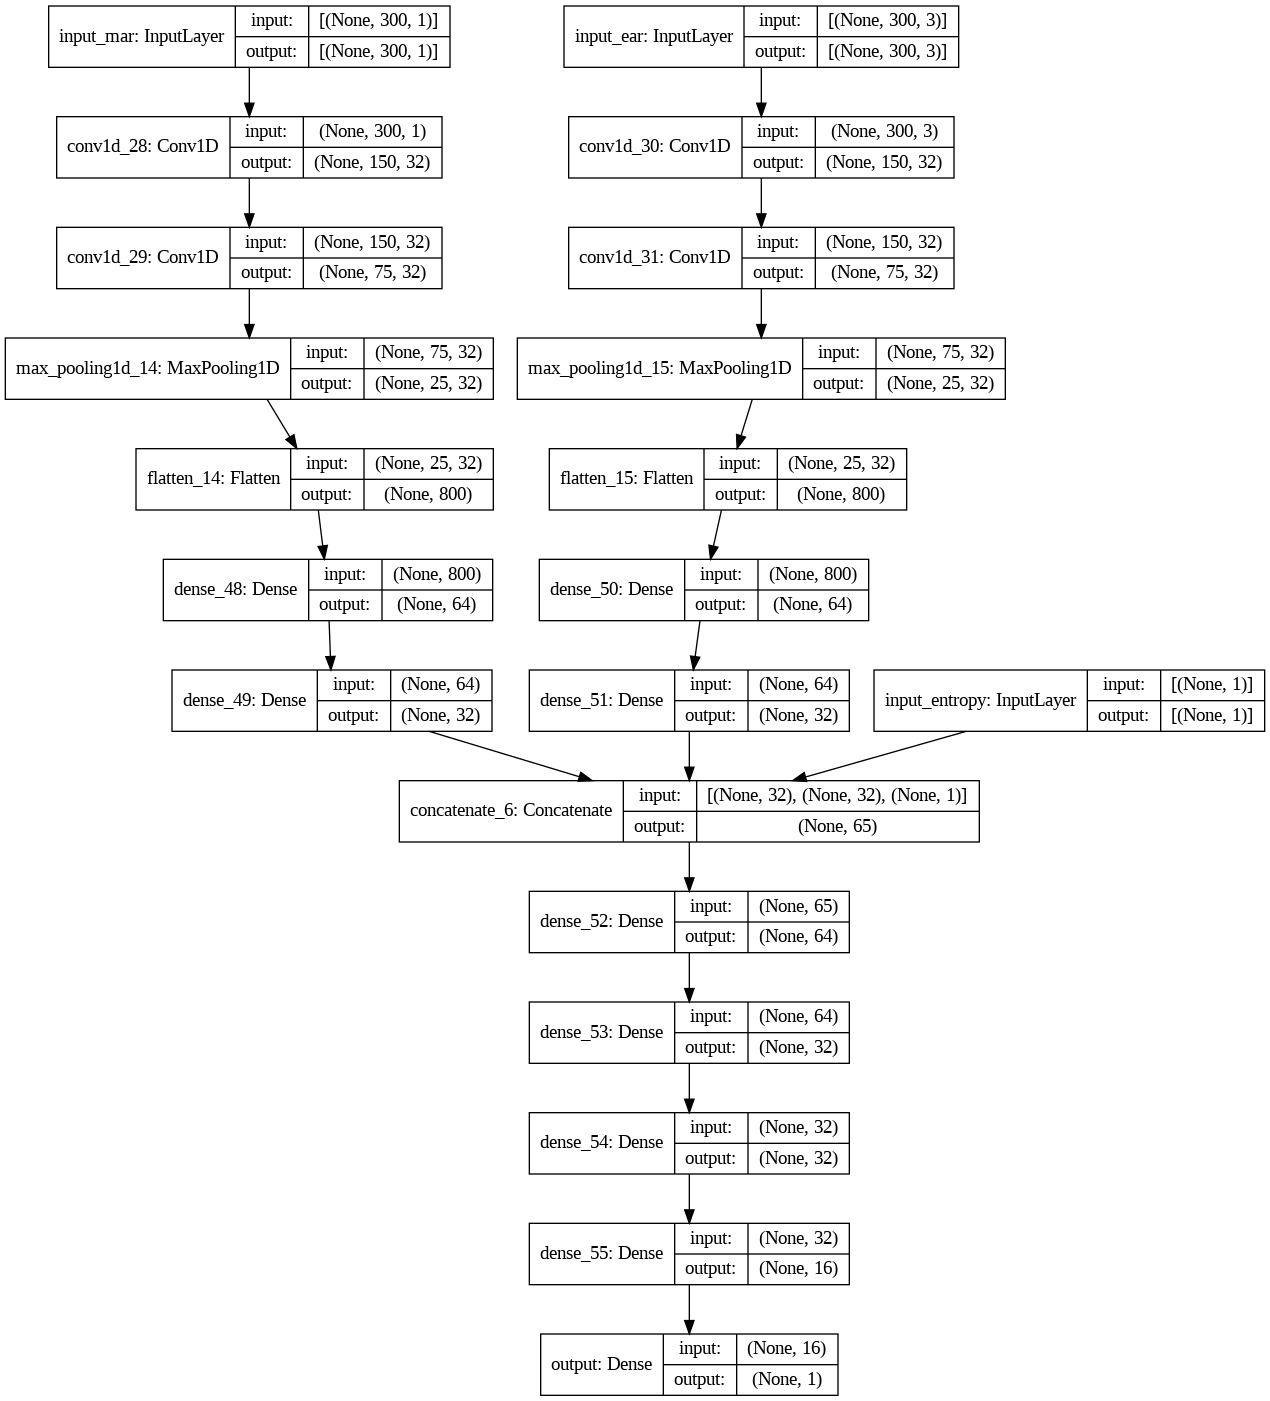

In [76]:
input_1 = keras.Input(shape=(300, 1), name='input_mar')
hidden_1 = layers.Conv1D(32, kernel_size=3, strides=2, padding='same', activation='tanh')(input_1)
hidden_1 = layers.Conv1D(32, kernel_size=3, strides=2, padding='same', activation='tanh')(hidden_1)
hidden_1 = layers.MaxPooling1D(pool_size=3, padding='valid')(hidden_1)
# hidden_1 = layers.BatchNormalization()(hidden_1)
hidden_1 = layers.Flatten()(hidden_1)
# hidden_1 = layers.LSTM(32, return_sequences=True)(hidden_1)
# hidden_1 = layers.LSTM(32)(hidden_1)
hidden_1 = layers.Dense(64, activation='tanh')(hidden_1)
hidden_1 = layers.Dense(32, activation='tanh')(hidden_1)

input_2 = keras.Input(shape=(300, 3), name='input_ear')
hidden_2 = layers.Conv1D(32, kernel_size=3, strides=2, padding='same', activation='tanh')(input_2)
hidden_2 = layers.Conv1D(32, kernel_size=3, strides=2, padding='same', activation='tanh')(hidden_2)
hidden_2 = layers.MaxPooling1D(pool_size=3, padding='valid')(hidden_2)
# hidden_2 = layers.BatchNormalization()(hidden_2)
hidden_2 = layers.Flatten()(hidden_2)
hidden_2 = layers.Dense(64, activation='tanh')(hidden_2)
hidden_2 = layers.Dense(32, activation='tanh')(hidden_2)

input_3 = keras.Input(shape=(1, ), name='input_entropy')
# hidden_3 = layers.Dense(32, activation="tanh")(input_3)
# hidden_3 = layers.BatchNormalization()(hidden_3)
# hidden_3 = layers.Dense(32, activation='tanh')(hidden_3)

concat = layers.Concatenate(axis=-1)([hidden_1, hidden_2, input_3])
concat_h1 = layers.Dense(64, activation='tanh')(concat)
concat_h1 = layers.Dense(32, activation='tanh')(concat_h1)
# concat_h1 = layers.BatchNormalization()(concat_h1)
concat_h1 = layers.Dense(32, activation='tanh')(concat_h1)
concat_h1 = layers.Dense(16, activation='tanh')(concat_h1)
output = layers.Dense(1, activation='tanh', name='output')(concat_h1)

model = keras.Model(inputs=[input_1, input_2, input_3], outputs=[output])
params_num = model.count_params()
print(f'params_num = {params_num}')
model.summary()
plot_model(model, show_shapes=True)

##### 開始訓練

In [77]:
''' trainParam '''
save_models = 'output_models'
model_tag = 'newtest_2'
optimizer = "adam"
loss = "mse"
batch_size = 128
epochs = 10000
time_tag = time.strftime("%Y_%m_%d-%H_%M_%S", time.localtime())
model_dir = f'{time_tag}-{model_tag}-params_{params_num}-batch_{batch_size}-optimizer_{optimizer}-loss_{loss}'
print(os.path.join(save_models, model_dir))
callbacks = list()
model.compile(optimizer="adam", loss="mse", metrics=['mae', 'acc'])
''' EarlyStopping '''
callbacks.append(
    keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
)
''' ModelCheckpoint '''
model_name = 'epoch_{epoch:03d}-val_loss_{val_loss:.3f}.hdf5'
all_filepath = os.path.join(save_models, model_dir, 'all_models', model_name)
callbacks.append(
    keras.callbacks.ModelCheckpoint(all_filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
)
best_filepath = os.path.join(save_models, model_dir, 'model.hdf5')
callbacks.append(
    keras.callbacks.ModelCheckpoint(best_filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
)
''' TensorBoard '''
log_dir = os.path.join(save_models, 'logs', model_dir)
callbacks.append(
    keras.callbacks.TensorBoard(log_dir=log_dir)
)

output_models/2022_04_29-09_35_12-newtest_2-params_121249-batch_128-optimizer_adam-loss_mse


In [78]:
trainHistory = model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    callbacks=callbacks
)

Epoch 1/10000
799/799 [==============================] - 10s 11ms/step - loss: 0.0914 - mae: 0.1917 - acc: 0.8784 - val_loss: 0.0396 - val_mae: 0.0830 - val_acc: 0.9533
Epoch 2/10000
799/799 [==============================] - 9s 11ms/step - loss: 0.0385 - mae: 0.0861 - acc: 0.9559 - val_loss: 0.0288 - val_mae: 0.0768 - val_acc: 0.9683
Epoch 3/10000
799/799 [==============================] - 9s 11ms/step - loss: 0.0260 - mae: 0.0609 - acc: 0.9707 - val_loss: 0.0174 - val_mae: 0.0447 - val_acc: 0.9809
Epoch 4/10000
799/799 [==============================] - 9s 11ms/step - loss: 0.0164 - mae: 0.0426 - acc: 0.9819 - val_loss: 0.0116 - val_mae: 0.0370 - val_acc: 0.9883
Epoch 5/10000
799/799 [==============================] - 9s 11ms/step - loss: 0.0118 - mae: 0.0336 - acc: 0.9867 - val_loss: 0.0091 - val_mae: 0.0306 - val_acc: 0.9886
Epoch 6/10000
799/799 [==============================] - 9s 11ms/step - loss: 0.0081 - mae: 0.0267 - acc: 0.9906 - val_loss: 0.0048 - val_mae: 0.0139 - val_acc

In [79]:
best_model_epoch = trainHistory.history['loss'].index(min(trainHistory.history['loss'])) + 1
with open(os.path.join(save_models, model_dir, 'READMD.md'), 'w', encoding='utf-8') as file:
    file.write('訓練結果：\n')
    file.write(f'\t{trainHistory.history.keys()}\n')
    file.write(f'\tbest_model_epoch = {best_model_epoch}\n')

**繪製Loss線**

2022_04_29-09_35_12-newtest_2-params_121249-batch_128-optimizer_adam-loss_mse-history_loss.jpg


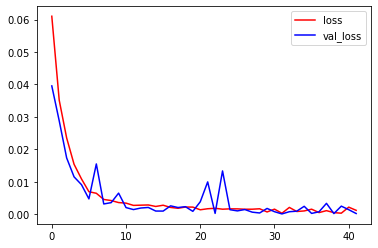

2022_04_29-09_35_12-newtest_2-params_121249-batch_128-optimizer_adam-loss_mse-history_acc.jpg


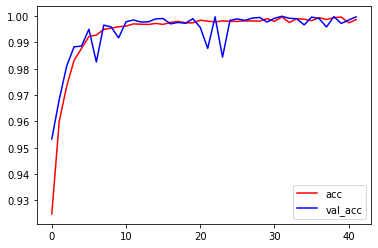

In [80]:
def draw_history(key):
    filename = f'{model_dir}-history_{key}.jpg'
    path = os.path.join(save_models, model_dir, filename)
    plt.plot(trainHistory.history[key], color='r', label=key)
    plt.plot(trainHistory.history[f'val_{key}'], color='b', label=f'val_{key}')
    plt.legend()
    print(filename)
    plt.savefig(path)
    plt.show()

draw_history('loss')
draw_history('acc')

### 匯出模型

# 測試模型

In [86]:
len(X_test[0])

12774

In [88]:
start_time = time.time()
predicted = model.predict(X_test)
print(f'runtime = {(time.time() - start_time) * 1000:.2f}ms')

runtime = 1339.02ms


In [ ]:
for i in range(10):
    start_time = time.time()
    predicted = model.predict([X_test[i]])
    print(f'runtime = {(time.time() - start_time) * 1000:.2f}ms')

In [100]:
max_loss = list()
sum = 0
for i, y in enumerate(Y_test):
    ans = abs(y - predicted[i][0])
    if ans > 0.0075:
        max_loss.append((i, ans))
    sum += ans
    # print(f'{ans:.2f}, {predicted[i][0]:.2f}, {y}')
print(f'acc = {1 - sum / (len(Y_test) * 100):.5f}%')
print(f'len(Y_test) = {len(Y_test)}')
print(f'len(max_loss) = {len(max_loss)}')

acc = 0.99999%
len(Y_test) = 12774
len(max_loss) = 219


In [91]:
with open(os.path.join(save_models, model_dir, 'READMD.md'), 'a', encoding='utf-8') as file:
    file.write('測試結果：\n')
    file.write(f'\tacc = {1 - sum / (len(Y_test) * 100):.5f}%\n')

212, loss = 0.03202640637755394


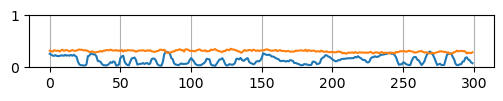

4, loss = 0.012913763523101807


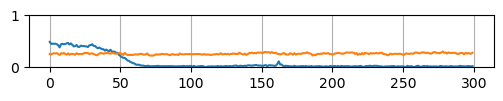

192, loss = 0.009537458419799805


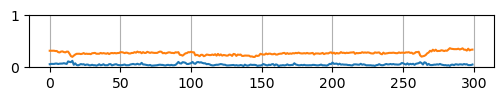

68, loss = 0.018325231969356537


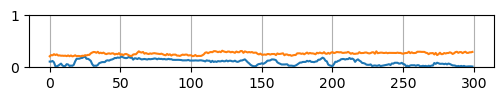

78, loss = 0.008963406085968018


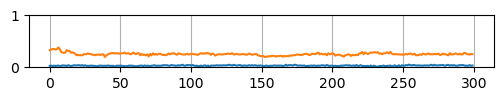

In [92]:
times = 5

def drawTrain(i, num):
    plt.figure(dpi=100)
    plt.subplot(10 + i + 100 * times)
    plt.plot(X_tests[num,:,0], label='mar')
    plt.plot(X_tests[num,:,1], label='entropy')
    print(f'{num}, loss = {max_loss[num][1]}')
    plt.ylim(0, 1)
    # plt.legend()
    plt.grid(True)
    plt.show()

def getRnd():
    return random.randint(0, len(max_loss) - 1)

for i in range(times):
    drawTrain(i + 1, getRnd())